In [2]:
import numpy as np
import pandas as pd

from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_curve, auc

from gmdhpy import gmdh

import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('./tested.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,0,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,1,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,0,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,0,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,1,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [4]:
df = df.drop(columns=['Cabin', 'Ticket', 'Name', 'PassengerId', 'Parch'])
df.head()

,Survived,Pclass,Sex,Age,SibSp,Fare,Embarked
0,0,3,male,34.5,0,7.8292,Q
1,1,3,female,47.0,1,7.0000,S
2,0,2,male,62.0,0,9.6875,Q
3,0,3,male,27.0,0,8.6625,S
4,1,3,female,22.0,1,12.2875,S


In [5]:
df.isna().sum()

Survived     0
Pclass       0
Sex          0
Age         86
SibSp        0
Fare         1
Embarked     0
dtype: int64

In [6]:
# Удаление строк с пропущенными значениями в столбце 'Fare'
df = df.dropna(subset=['Fare'])


In [7]:
# Создание фиктивных (бинарных) переменных для столбцов 'Sex' и 'Embarked'
dummies_df = pd.get_dummies(data=df[['Sex', 'Embarked']])
df = pd.concat([df, dummies_df], axis=1)
df = df.drop(columns=['Sex', 'Embarked'])
# Приведение столбцов 'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S' к типу int
df[['Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S']] = df[['Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S']].astype(int)
df.head()

,Survived,Pclass,Age,SibSp,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,3,34.5,0,7.8292,0,1,0,1,0
1,1,3,47.0,1,7.0000,1,0,0,0,1
2,0,2,62.0,0,9.6875,0,1,0,1,0
3,0,3,27.0,0,8.6625,0,1,0,0,1
4,1,3,22.0,1,12.2875,1,0,0,0,1


In [8]:
# Создание модели классификатора дерева решений
tree = DecisionTreeClassifier()

# Создание DataFrame с пропущенными значениями
new_df_with_na = df[df.isna().any(axis=1)].drop(columns=['Age'])
# Создание DataFrame без пропущенных значений
new_df_without_na = df.dropna(subset=['Age'])

# Создание столбца с целевыми переменными в DataFrame без пропущенных значений
new_df_without_na_class = new_df_without_na['Age']
new_df_without_na_class = new_df_without_na_class.astype(int)

# Удаление столбца 'Age' из DataFrame без пропущенных значений
new_df_without_na = new_df_without_na.drop(columns=['Age'])

# Обучение модели дерева решений на DataFrame без пропущенных значений
tree.fit(new_df_without_na, new_df_without_na_class)
# Прогнозирование значений для пропущенных значений в DataFrame с использованием модели дерева решений
age_class = tree.predict(new_df_with_na)

# Заполнение столбца 'Age' прогнозированными значениями
new_df_with_na['Age'] = age_class
new_df_without_na['Age'] = new_df_without_na_class
new_df_without_na
# Объединение DataFrame без пропущенных значений и DataFrame с прогнозированными значениями
df = pd.concat([new_df_without_na, new_df_with_na])

df.isna().sum()

Survived      0
Pclass        0
SibSp         0
Fare          0
Sex_female    0
Sex_male      0
Embarked_C    0
Embarked_Q    0
Embarked_S    0
Age           0
dtype: int64

In [9]:
# Определение целевой переменной и удаление столбца 'Survived'
y_class = df['Survived']
df = df.drop(columns=['Survived'])

In [10]:
# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(df, y_class, test_size=0.1)
# Вывод размеров обучающей выборки и целевой переменной
X_train.shape, y_train.shape

((375, 9), (375,))

In [11]:
# Функция для построения ROC-кривой
def draw_roc(y_true, y_score, name):
    fpr, tpr, thresholds = roc_curve(y_true=y_true, y_score=y_score)

    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')  # Plotting the diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title(f'ROC curve for {name}')
    plt.legend(loc="lower right")
    plt.show()

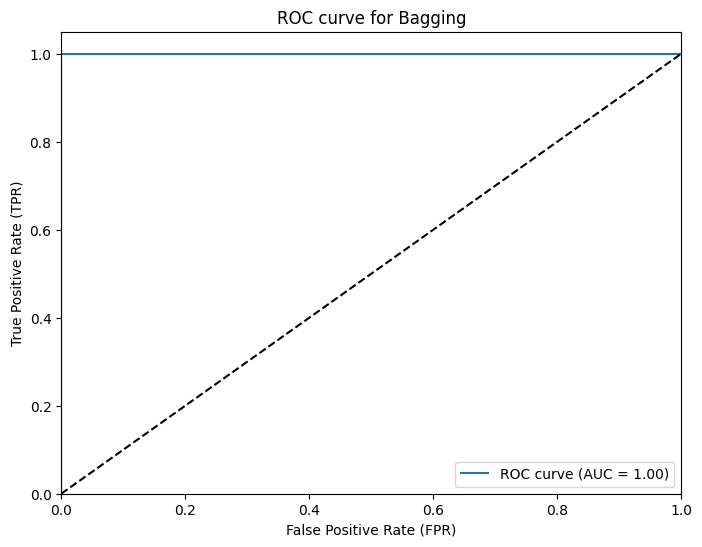

In [12]:
# Создание модели BaggingClassifier
bc = BaggingClassifier()
bc.fit(X=X_train, y=y_train)
predicted_class = bc.predict(X_test)
# Вычисление F1-меры для модели BaggingClassifier
f1_score(y_true=y_test, y_pred=predicted_class)

# Построение ROC-кривой для модели BaggingClassifier
draw_roc(y_true=y_test, y_score=predicted_class, name='Bagging')

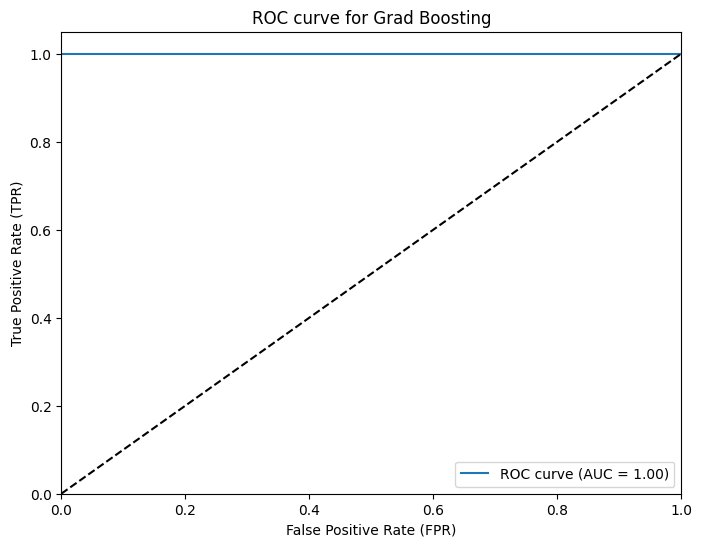

In [13]:
# Создание модели GradientBoostingClassifier
grad_boost = GradientBoostingClassifier()
grad_boost.fit(X=X_train, y=y_train)
predicted_class = grad_boost.predict(X_test)
# Вычисление F1-меры для модели GradientBoostingClassifier
f1_score(y_true=y_test, y_pred=predicted_class)

# Построение ROC-кривой для модели GradientBoostingClassifier
draw_roc(y_true=y_test, y_score=predicted_class, name='Grad Boosting')


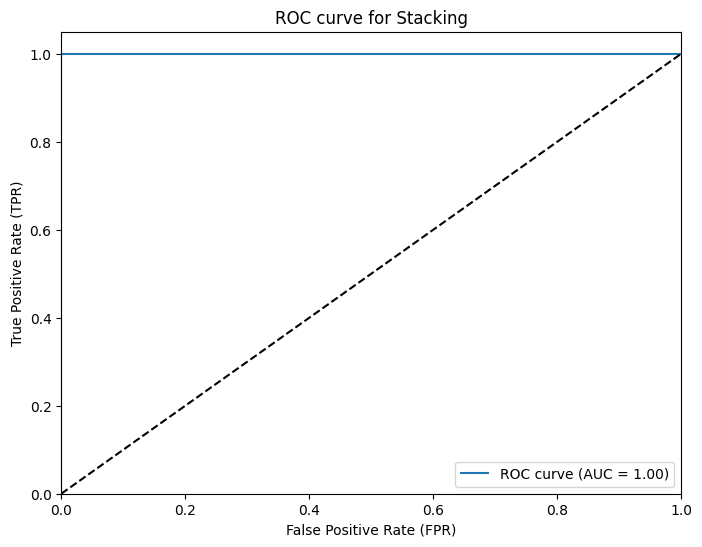

In [14]:
# Создание списка моделей и выбор окончательной модели для StackingClassifier
estamators = [
    ('decision_tree', DecisionTreeClassifier()),
    ('linear_regression', LinearRegression()),
    ('svm', SVC())
]

final_estimator = DecisionTreeClassifier()

# Создание модели StackingClassifier
stack = StackingClassifier(estimators=estamators, final_estimator=final_estimator)
stack.fit(X=X_train, y=y_train)
predicted_class = stack.predict(X_test)

# Построение ROC-кривой для модели StackingClassifier
draw_roc(y_true=y_test, y_score=predicted_class, name='Stacking')

/Users/stayfly/vscode/tmo/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


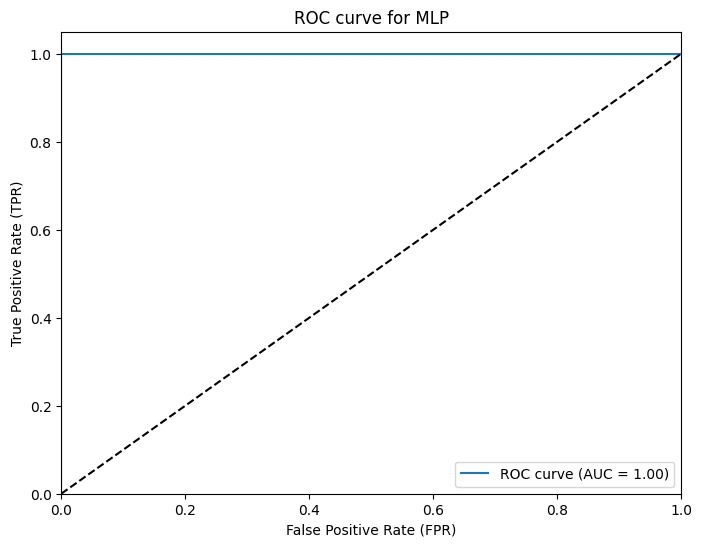

In [15]:
# Создание модели MLPClassifier
perceptron = MLPClassifier()
perceptron.fit(X=X_train, y=y_train)
predicted_class = perceptron.predict(X_test)

# Построение ROC-кривой для модели MLPClassifier
draw_roc(y_true=y_test, y_score=predicted_class, name='MLP')

train layer0 in 0.15 sec
train layer1 in 0.24 sec
train layer2 in 0.24 sec
train layer3 in 0.24 sec
train layer4 in 0.24 sec
train layer5 in 0.25 sec
train layer6 in 0.25 sec
train layer7 in 0.23 sec
train layer8 in 0.26 sec
train layer9 in 0.25 sec
train layer10 in 0.24 sec
train layer11 in 0.26 sec
train layer12 in 0.24 sec
train layer13 in 0.24 sec
train layer14 in 0.24 sec
train layer15 in 0.24 sec
train layer16 in 0.29 sec
train layer17 in 0.25 sec
train layer18 in 0.29 sec
train layer19 in 0.28 sec
train layer20 in 0.38 sec
train layer21 in 0.24 sec
train layer22 in 0.24 sec
train layer23 in 0.30 sec
train layer24 in 0.23 sec
train layer25 in 0.25 sec
train layer26 in 0.39 sec
train layer27 in 0.25 sec
train layer28 in 0.53 sec
train layer29 in 0.38 sec
train layer30 in 0.48 sec
train layer31 in 0.35 sec
train layer32 in 0.30 sec
train layer33 in 0.40 sec
train layer34 in 0.35 sec
train layer35 in 0.28 sec
train layer36 in 0.29 sec
train layer37 in 0.32 sec
train layer38 in 0.33 

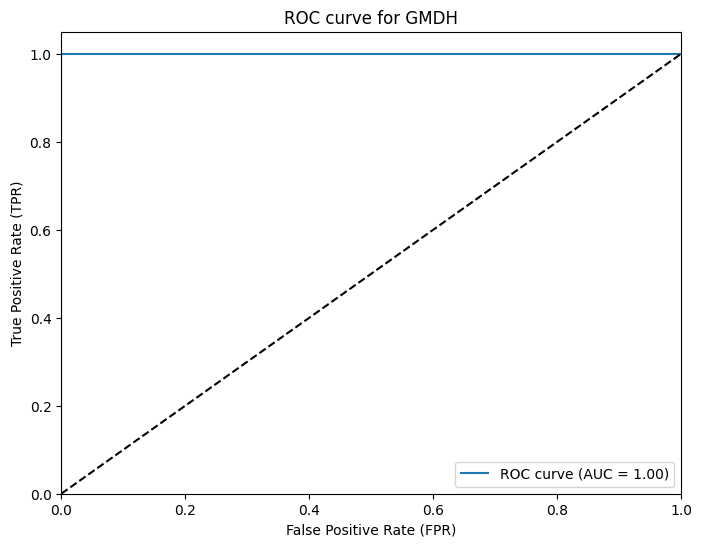

In [16]:
# Создание модели gmdhpy.MultilayerGMDH
mgua = gmdh.MultilayerGMDH()

# Преобразование данных в массивы NumPy
np_X_train = np.array(X_train)
np_y_train = np.array(y_train)

# Обучение модели gmdhpy.MultilayerGMDH на обучающих данных
mgua.fit(np_X_train, np_y_train)

np_X_test = np.array(X_test)

# Прогнозирование классов на тестовых данных с помощью модели gmdhpy.MultilayerGMDH
predicted_class = mgua.predict(np_X_test)

# Построение ROC-кривой для модели gmdhpy.MultilayerGMDH
draw_roc(y_true=y_test, y_score=predicted_class, name='GMDH')